# Loading Packages

In [3]:
%pip install pyfeats

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 80.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 83.4 MB/s eta 0:00:00
  Created wheel for pyfeats: filename=pyfeats-1.0.1-py3-none-any.whl size=49855 sha256=f30f99f539dc52dfefb799bbfc562a4af3058671cc71a33a8437e901868701f9
  Stored in directory: /Users/alex/Library/Caches/pip/wheels/9c/51/9f/9043a10f17aae1e028aeec62ff09017262ed01fb0ab52b1cc2
  Created wheel for mahotas: filename=mahotas-1.4.18-cp313-cp313-macosx_15_0_arm64.whl size=1786519 sha256=9674667bf5cee3fa2bf955a1185

In [4]:
import os
import torch
from utils.visualize       import visualize_images_from_classes
from utils.datasets        import returnDataLoader, extract_selected_features, load_images_and_labels
from utils.model_execution import runFMA, runDLA, runKBA
from utils.analysis        import print_analysis

/Users/alex/programming/python/HistoART/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.xpu.is_available():
    device = torch.device("xpu")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: xpu


# Load Patches

In [3]:
test = True

if(test):
    data_dir = './data/combined/'
    classes  = ['artifact_free', 'blur']

else:
    while True:
        data_dir = input("Please enter the dataset directory, for example: ./data/: ") or "./data/combined/"

        if not os.path.isdir(data_dir):
            print(f"Directory '{data_dir}' does not exist. Please try again.\n")
            continue
        print("\nDataset directory confirmed.\n")

        break

    classes            = []
    artifact_free      = input("Please enter the name of the artifact free folder (e.g., artifact_free): ").strip()
    artifact_free_path = os.path.join(data_dir, artifact_free)

    if artifact_free and os.path.isdir(artifact_free_path):
        classes.append(artifact_free)
        print(f"Folder '{artifact_free_path}' exists and was added as artifact free.")
    else:
        if artifact_free:
            print(f"Folder '{artifact_free_path}' does not exist. Please check the name.")

    artifact      = input("Please enter the name of the artifact folder (e.g., artifact): ").strip()
    artifact_path = os.path.join(data_dir, artifact)

    if artifact and os.path.isdir(artifact_path):
        classes.append(artifact)
        print(f"Folder '{artifact_path}' exists and was added as artifact.")
    else:
        if artifact:
            print(f"Folder '{artifact_path}' does not exist. Please check the name.")

    if classes:
        print("\nDataset loaded successfully.")
    else:
        print("\nNo valid class folders were provided. Defaulting to sample classes.")
        classes = ['artifact_free', 'blur']


# Random visualization of different classes

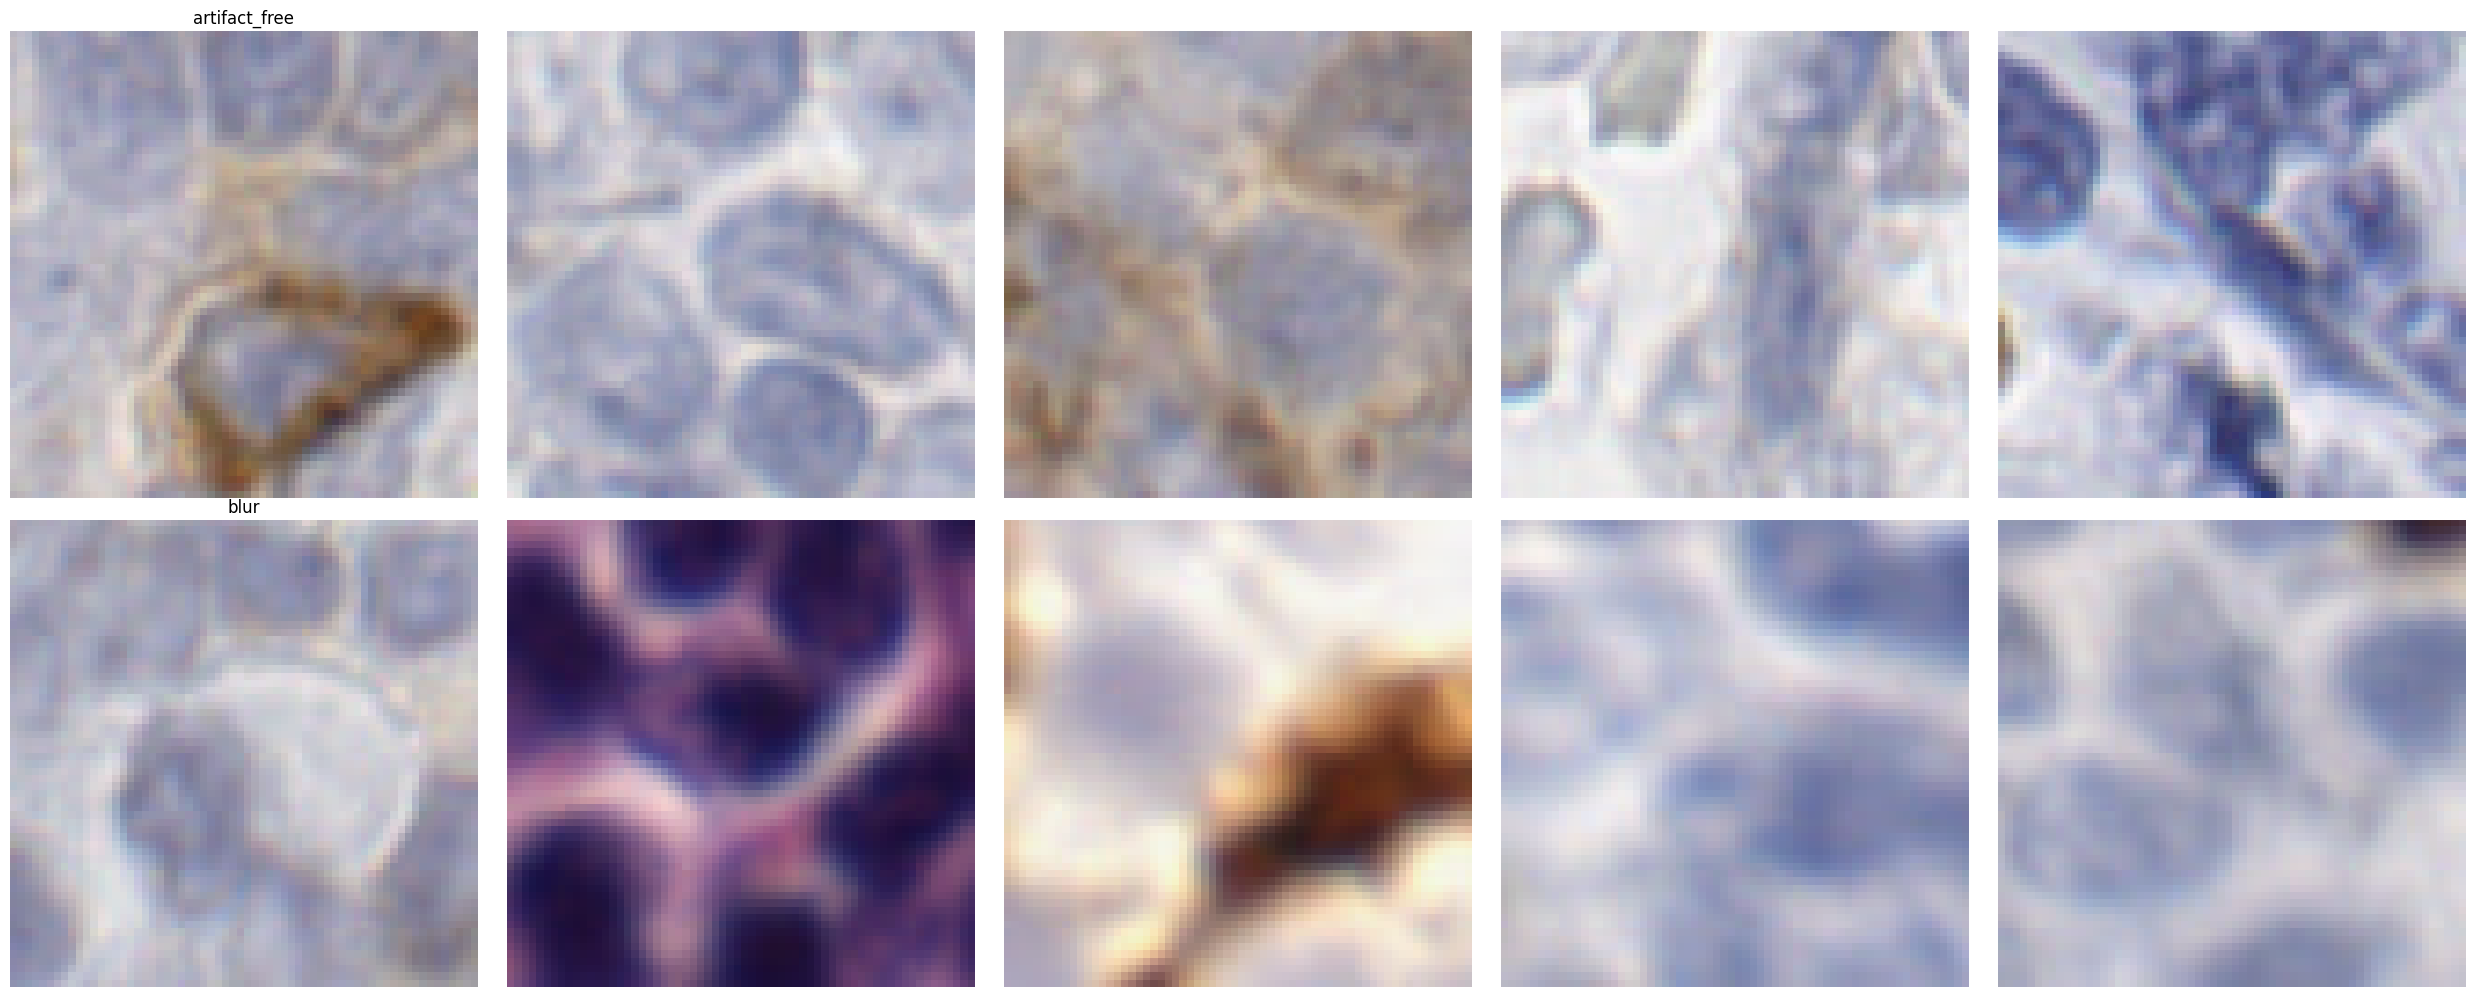

In [4]:
visualize_images_from_classes(data_dir, classes)

# Prepare data for classification

In [ ]:
fma_dataloader = returnDataLoader(data_dir, classes, 32)
dla_dataloader = returnDataLoader(data_dir, classes, 128)

print("Total dataset size (samples): ", len(dla_dataloader.dataset))

Total dataset size (samples):  222495


In [6]:
X, y           = load_images_and_labels(data_dir, classes)

Loading 'blur': 100%|██████████| 100006/100006 [01:21<00:00, 1220.24it/s]


In [ ]:
X_feat, y_feat = extract_selected_features(X, y)

# Classify images with different models

### FMA

In [ ]:
runFMA(fma_dataloader, device, './models/fma_binary_blur.pth')

### DLA

In [ ]:
runDLA(dla_dataloader, device, './models/dla_binary_blur.pth')

### KBA

In [18]:
runKBA(X_feat, y_feat, './models/kba_binary.pkl')

Predictions saved to 'kba_results.csv'.


# Analysis

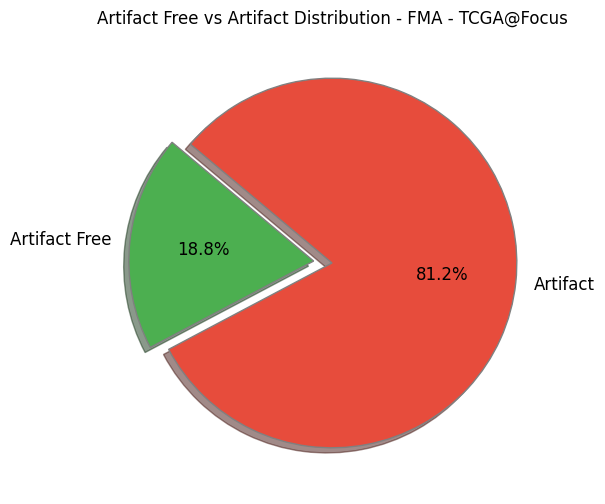

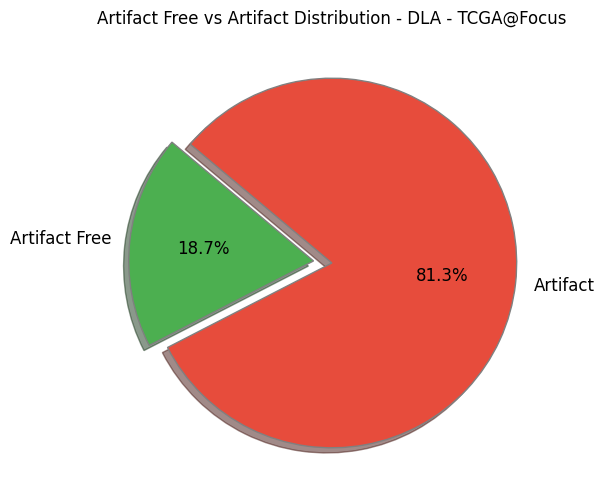

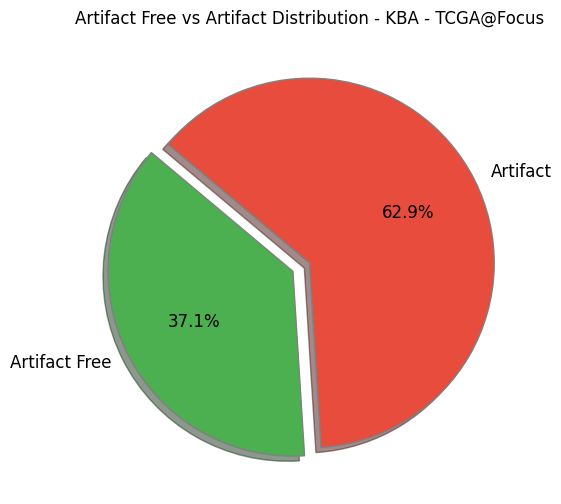

In [7]:
print_analysis('./results/fma/fma_binary_external_tcga.csv', "FMA - TCGA@Focus")
print_analysis('./results/dla/dla_binary_external_tcga.csv', "DLA - TCGA@Focus")
print_analysis('./results/kba/kba_binary_external_tcga.csv', "KBA - TCGA@Focus")

actual:
- 78.3% artifact-free
- 21.7% artifact

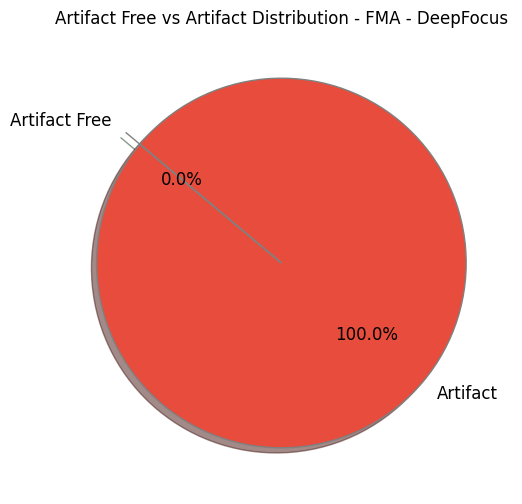

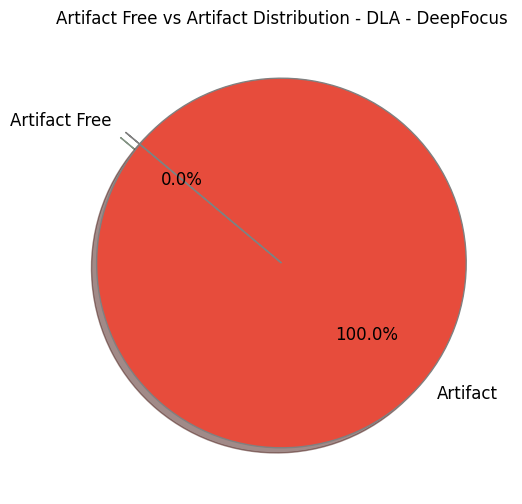

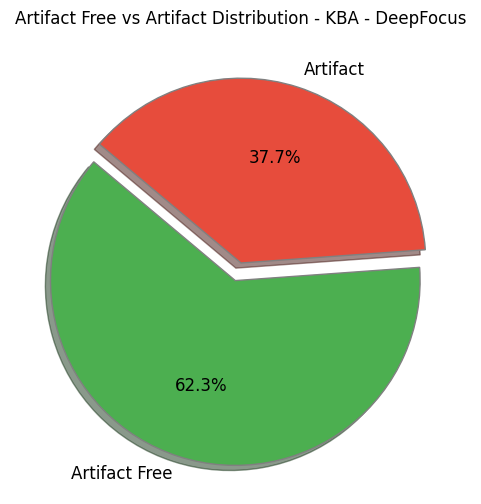

In [10]:
print_analysis('./results/fma/fma_binary_external_deepfocus.csv', "FMA - DeepFocus")
print_analysis('./results/dla/dla_binary_external_deepfocus.csv', "DLA - DeepFocus")
print_analysis('./results/kba/kba_binary_external_deepfocus.csv', "KBA - DeepFocus")

actual:
- 52.9% artifact-free
- 47.1% artifact